# Comparing the different velocity components betwen N2Hp and HC3N

In [1]:
import numpy as np
import os
import pandas as pd

import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord, FK5
from astropy.visualization.wcsaxes import add_beam, add_scalebar
from reproject import reproject_interp

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import cm
from matplotlib.colors import AsinhNorm

from copy import copy

%matplotlib widget

In [2]:
velcubehc3nfile = '../bayes_frame/nested-sampling/HC3N/vel_components_cube_filtered_QA.fits'
velcuben2hpfile = '../bayes_frame/nested-sampling/N2Hp/vel_components_cube_filtered_QA.fits'
mlex1n2hpfile = '../bayes_frame/nested-sampling/N2Hp/NGC1333-SE-mle-x1_filtered_QA.fits'
mlex2n2hpfile = '../bayes_frame/nested-sampling/N2Hp/NGC1333-SE-mle-x2_filtered_QA.fits'
mom0n2hpfile = '../data/NGC1333-N2Hp_match_kms_F1F_01_12_K_5_10_mom0.fits' #mom0 of the files used to fit the spectra
mom0hc3nfile = '../data/NGC1333_HC3N_L24-merged_small_K_-3.0_18.0_mom0.fits'
sourcecat = '../data/Tobin_2018_Perseus_cat_NGC1333SE.csv'

In [3]:
# here we load the files in their original grid
velcubehc3n, headervelcubehc3n = fits.getdata(velcubehc3nfile, header=True)
velcuben2hp, headervelcuben2hp = fits.getdata(velcuben2hpfile, header=True)
headern2hp = fits.getheader(mom0n2hpfile)
headerhc3n = fits.getheader(mom0hc3nfile)
wcssky = WCS(headern2hp).celestial
#catalog of protostars
catalog_protostars = pd.read_csv(sourcecat)

In [4]:
# here we reproject the HC3N velocity planes to the N2Hp grid
velcubehc3n1, velcubehc3n2, velcubehc3n3 = velcubehc3n
velcuben2hp1, velcuben2hp2 = velcuben2hp
velcubehc3n1new, velfootprint = reproject_interp(fits.PrimaryHDU(data=velcubehc3n1, header=headerhc3n), headern2hp)
velcubehc3n2new, _footprint = reproject_interp(fits.PrimaryHDU(data=velcubehc3n2, header=headerhc3n), headern2hp)
velcubehc3n3new, _footprint = reproject_interp(fits.PrimaryHDU(data=velcubehc3n3, header=headerhc3n), headern2hp)
velcubehc3nnew = [velcubehc3n1new, velcubehc3n2new, velcubehc3n3new]
# building the new header
headervelcubehc3nnew = headervelcubehc3n.copy()
headervelcubehc3nnew['NAXIS1'] = headern2hp['NAXIS1']
headervelcubehc3nnew['NAXIS2'] = headern2hp['NAXIS2']
headervelcubehc3nnew['CDELT1'] = headern2hp['CDELT1']
headervelcubehc3nnew['CDELT2'] = headern2hp['CDELT2']
headervelcubehc3nnew['CRVAL1'] = headern2hp['CRVAL1']
headervelcubehc3nnew['CRVAL2'] = headern2hp['CRVAL2']
headervelcubehc3nnew['CRPIX1'] = headern2hp['CRPIX1']
headervelcubehc3nnew['CRPIX2'] = headern2hp['CRPIX2']
# save the results
fits.writeto(velcubehc3nfile[:-5]+'_reproject.fits', velcubehc3nnew, headervelcubehc3nnew, overwrite=True)

In [5]:
# now that they have the same projection, we can compare the velocity.
# we subtract HC3N from N2Hp to see the relative movement of HC3N with respect to N2Hp
deltav1 = velcubehc3n1new - velcuben2hp1
deltav2 = velcubehc3n1new - velcuben2hp2

print('Basic info:')
print('Maximum difference between comp.1', np.nanmax(deltav1))
print('Maximum negative difference between comp.1', np.nanmin(deltav1))
print('Average difference between comp.1', np.nanmean(deltav1))

print('Maximum difference between comp.2', np.nanmax(deltav2))
print('Maximum negative difference between comp.2', np.nanmin(deltav2))
print('Average difference between comp.2', np.nanmean(deltav2))

Basic info:
Maximum difference between comp.1 3.4045161374018464
Maximum negative difference between comp.1 -4.711799675725532
Average difference between comp.1 0.20129484546120913
Maximum difference between comp.2 2.0219640588513483
Maximum negative difference between comp.2 -5.213695926662779
Average difference between comp.2 -0.41280276051096043


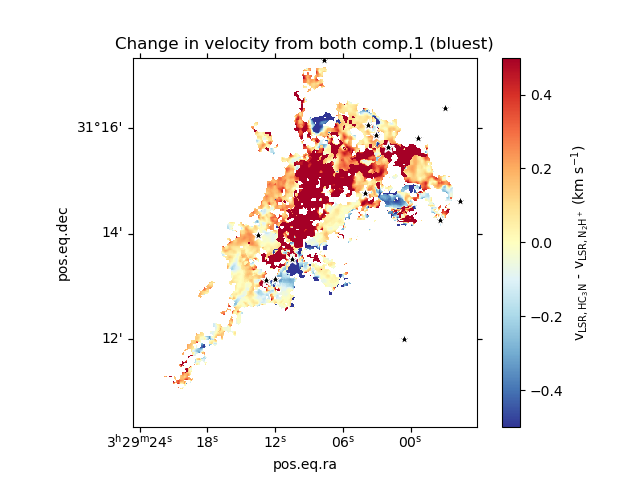

In [6]:
vmin =-0.5
vmax = 0.5


fig = plt.figure()
ax = fig.add_subplot(111, projection=wcssky)

im = ax.imshow(deltav1, cmap='RdYlBu_r', interpolation='nearest', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax, label=r'v$_{\mathrm{LSR, HC}_3\mathrm{N}}$ - v$_{\mathrm{LSR, N}_2\mathrm{H}^+}$ (km s$^{-1}$)')
ax.set_title('Change in velocity from both comp.1 (bluest)')
for i in catalog_protostars.index.values:
    ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
               transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70)
    
fig.savefig('comparison_blueshifted_comps_HC3NminusN2Hp.pdf', dpi=100, bbox_inches='tight')

From this plot we see that HC3N does not cover the middle part of the bluest component of N2Hp, so the two velocity layers are one over the other in N2Hp **but not in HC3N**. This is important for later comparison

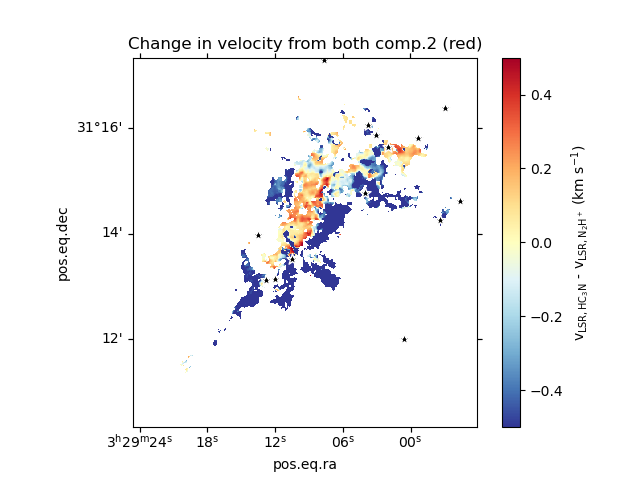

In [7]:
vmin =-0.5
vmax = 0.5


fig = plt.figure()
ax = fig.add_subplot(111, projection=wcssky)

im = ax.imshow(deltav2, cmap='RdYlBu_r', interpolation='nearest', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax, label=r'v$_{\mathrm{LSR, HC}_3\mathrm{N}}$ - v$_{\mathrm{LSR, N}_2\mathrm{H}^+}$ (km s$^{-1}$)')
ax.set_title('Change in velocity from both comp.2 (red)')
for i in catalog_protostars.index.values:
    ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
               transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70)
    
fig.savefig('comparison_redshifted_comps_HC3NminusN2Hp.pdf', dpi=100, bbox_inches='tight')

In [8]:
# we take the minimum difference to see the true distribution, as HC3N is mostly in two layers that do not overlap
deltavmin = np.where(~np.isnan(deltav1) & np.isnan(deltav2), deltav1, np.nan) # we first fill with the values that only have one option
indexv1 = np.where(~np.isnan(deltav1) & ~np.isnan(deltav2) & (np.abs(deltav1)<np.abs(deltav2)))
indexv2 = np.where(~np.isnan(deltav1) & ~np.isnan(deltav2) & (np.abs(deltav1)>=np.abs(deltav2)))


for y, x in zip(indexv1[0], indexv1[1]):
    deltavmin[y, x] = deltav1[y, x]
for y, x in zip(indexv2[0], indexv2[1]):
    deltavmin[y, x] = deltav2[y, x]

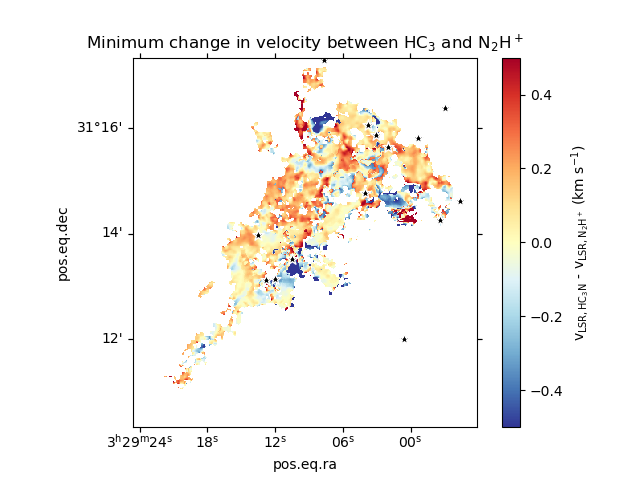

In [9]:
vmin =-0.5
vmax = 0.5


fig = plt.figure()
ax = fig.add_subplot(111, projection=wcssky)

im = ax.imshow(deltavmin, cmap='RdYlBu_r', interpolation='nearest', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax, label=r'v$_{\mathrm{LSR, HC}_3\mathrm{N}}$ - v$_{\mathrm{LSR, N}_2\mathrm{H}^+}$ (km s$^{-1}$)')
ax.set_title('Minimum change in velocity between HC$_3$ and N$_2$H$^+$')
for i in catalog_protostars.index.values:
    ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
               transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70)
    
fig.savefig('comparison_mindiff_comps_HC3NminusN2Hp.pdf', dpi=100, bbox_inches='tight')

## Rebuilding the velocity maps to compare

For the mid part of the filament, the most redshifted component of N2Hp should go with the 1 component fit of N2Hp for the subtraction. 

In [10]:
mlex1n2hp = fits.getdata(mlex1n2hpfile)
mlex2n2hp = fits.getdata(mlex2n2hpfile)

velcuben2hp1new = np.zeros(np.shape(velcuben2hp1)) * np.nan
mask1g = np.where(~np.isnan(mlex1n2hp[0]))
for y,x in zip(mask1g[0],mask1g[1]):
    velcuben2hp1new[y,x] = mlex1n2hp[1, y, x]
mask2g = np.where(~np.isnan(mlex2n2hp[0]))
for y,x in zip(mask2g[0],mask2g[1]): # here we use the reddest instead of the bluest
    velcuben2hp1new[y,x] = mlex2n2hp[4, y, x]

In [11]:
deltav1new = velcubehc3n1new - velcuben2hp1new

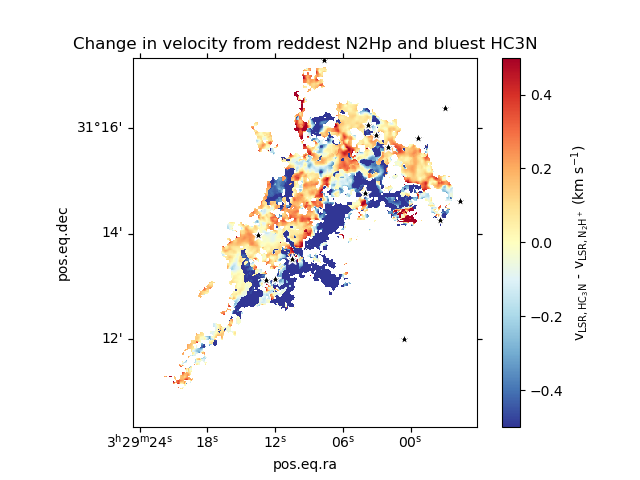

In [12]:
vmin =-0.5
vmax = 0.5

fig = plt.figure()
ax = fig.add_subplot(111, projection=wcssky)

im = ax.imshow(deltav1new, cmap='RdYlBu_r', interpolation='nearest', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax, label=r'v$_{\mathrm{LSR, HC}_3\mathrm{N}}$ - v$_{\mathrm{LSR, N}_2\mathrm{H}^+}$ (km s$^{-1}$)')
ax.set_title('Change in velocity from reddest N2Hp and bluest HC3N')
for i in catalog_protostars.index.values:
    ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
               transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70)